In [1]:
# !pip install -q -r requirements.txt

In [2]:
# !apt-get update >/dev/null
# !apt-get -y install python3-dev libsm-dev libxrender1 libxext6 zip git >/dev/null
# !rm -rf /var/lib/apt/lists/*

In [3]:
# !git pull

In [4]:
import glob
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from train import create_model, create_criterion, evaluate
from dataset import TrainData, TrainDataset

In [5]:
input_dir = "/storage/kaggle/quickdraw"
image_size = 32
batch_size = 256
test_size = 0.1
train_on_unrecognized = True
num_categories_restriction = 68
num_workers = 8
pin_memory = True
use_dummy_image = False

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
model = create_model("cnn", input_size=image_size, num_classes=68)
model.load_state_dict(torch.load("/storage/models/quickdraw/test/model.pth", map_location=device))

In [8]:
train_data = TrainData(
    input_dir,
    shard=0,
    test_size=test_size,
    train_on_unrecognized=train_on_unrecognized,
    num_categories_restriction=num_categories_restriction)

Reading data file '/storage/kaggle/quickdraw/train_simplified_shards/shard-0.npz'
Loaded 994325 samples
Time to load data of shard 0: 0:00:26.963200


In [9]:
val_set = TrainDataset(train_data.val_set_df, image_size, use_dummy_image)
val_set_data_loader = \
    DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [10]:
criterion = create_criterion("cce", len(train_data.categories))

In [11]:
loss_avg, mapk_avg, accuracy_top1_avg, accuracy_top3_avg, accuracy_top5_avg, accuracy_top10_avg = \
    evaluate(model, val_set_data_loader, criterion, 3)

In [12]:
print(
    "loss: {:.2f}, map@3: {:.2f}, acc@1: {:.2f}, acc@3: {:.2f}, acc@5: {:.2f}, acc@10: {:.2f}"
    .format(loss_avg, mapk_avg, accuracy_top1_avg, accuracy_top3_avg, accuracy_top5_avg, accuracy_top10_avg))

loss: 0.58, map@3: 0.89, acc@1: 0.85, acc@3: 0.94, acc@5: 0.96, acc@10: 0.97


In [13]:
val_set_data_loader_iter = iter(val_set_data_loader)

In [14]:
batch = next(val_set_data_loader_iter)

images, categories = \
    batch[0].to(device, non_blocking=True), \
    batch[1].to(device, non_blocking=True)

In [15]:
prediction_logits = model(images)
predictions = F.softmax(prediction_logits, dim=1)

In [16]:
prediction_scores, prediction_categories = predictions.topk(3, dim=1, sorted=True)

In [17]:
print(prediction_scores[:10, 0])

tensor([0.7108, 1.0000, 0.9960, 0.9998, 0.8685, 0.9865, 1.0000, 0.9916, 0.7663,
        0.9828], device='cuda:0', grad_fn=<SelectBackward>)


In [18]:
print(np.array(train_data.categories)[prediction_categories[:10, 0]])

['blackberry' 'cello' 'ant' 'bowtie' 'blueberry' 'blueberry' 'bowtie'
 'binoculars' 'cake' 'cello']


In [19]:
print(prediction_scores[:, 0].mean())
print(prediction_scores[:, 0].std())
print(prediction_scores[:, 0].min())
print(prediction_scores[:, 0].max())

tensor(0.8316, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.2340, device='cuda:0', grad_fn=<StdBackward0>)
tensor(0.1256, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


In [20]:
print(prediction_scores[categories == 0][:, 0].mean())
print(prediction_scores[categories == 0][:, 0].std())
print(prediction_scores[categories == 0][:, 0].min())
print(prediction_scores[categories == 0][:, 0].max())

tensor(0.9923, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0103, device='cuda:0', grad_fn=<StdBackward0>)
tensor(0.9746, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


In [21]:
confusion = np.zeros((len(train_data.categories), len(train_data.categories)))
for c, pc in zip(categories, prediction_categories):
    confusion[c, pc] += 1

In [22]:
print(confusion.mean())
print(confusion.std())
print(confusion.min())
print(confusion.max())

0.16608996539792387
0.7059501968889463
0.0
9.0


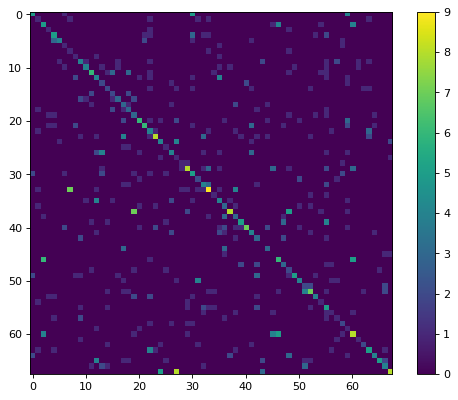

In [23]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor="w", edgecolor="k")
plt.imshow(confusion, vmin=confusion.min(), vmax=confusion.max())
plt.colorbar()